# Many redundant libraries are loaded, some have different names so need to agree on one and update uses throughout the code

In [1]:
#importing all necessary libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from tqdm import tnrange, tqdm_notebook
from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import precision_recall_curve

C:\Users\david\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\david\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## Data quality check / cleaning / preparation 

### Data quality check
*By Jazmyn Lu*

In [2]:
train = pd.read_csv('../train.csv') #taking a quick peek at the data!
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.isnull().sum() #there seems to be a lot of missing values of age and cabin

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
train.shape

(891, 12)

There are only 204 observations for "Cabin", and so it's probably not worth imputing those data points. Moreover, after some preliminary research, I found that Cabins are just divided by Pclass, a variable we already have, so even if we did include it in the model, they would be correlated variables. What may be informative, however, is imputing values of Age. Let's explore that:

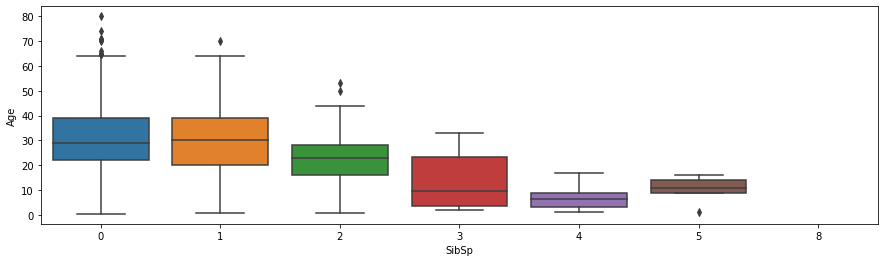

In [5]:
ax = sns.boxplot(x="SibSp", y = 'Age',  data=train)
ax.figure.set_figwidth(15)

Seems like there is a trend where increased number of siblings and spouses means smaller age

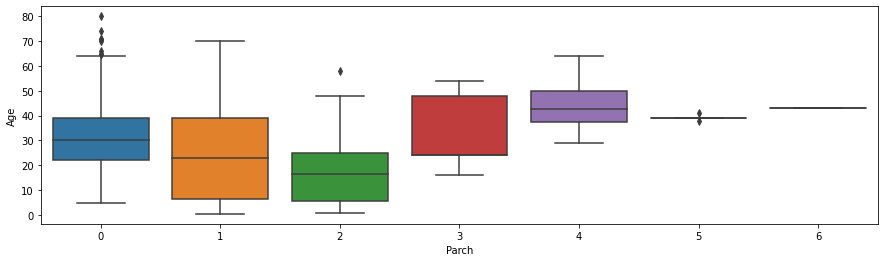

In [6]:
ax = sns.boxplot(x="Parch", y = 'Age',  data=train)
ax.figure.set_figwidth(15)

There also seems to be some correlation

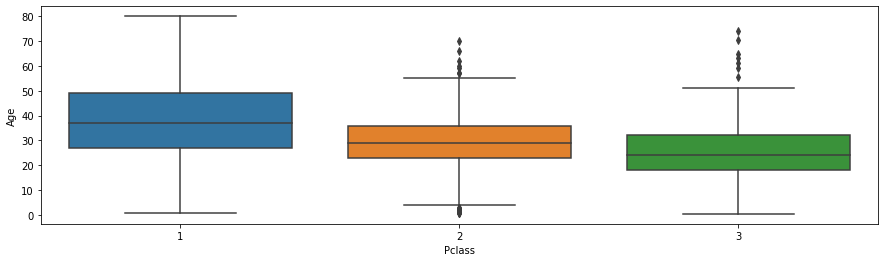

In [7]:
ax = sns.boxplot(x="Pclass", y = 'Age',  data=train)
ax.figure.set_figwidth(15)

Higher class, older people

Text(0.5, 1.0, 'Age vs Fare')

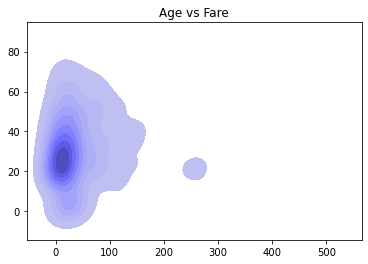

In [8]:
sns.kdeplot(train['Fare'].values, y=train['Age'].values,color='blue',shade=True )
plt.title("Age vs Fare")

Some association between Fare and Age

In [9]:
#PClass, Parch, and SibSp variables are categorical, not numerical. Transform to strings so model treats it as categorical
train['Pclass'] = train['Pclass'].apply(str)
train['Parch'] = train['Parch'].apply(str)
train['SibSp'] = train['SibSp'].apply(str)

In [10]:
missing_age = train[train['Age'].isna()] #dataframe containing only rows missing Age
has_age = train.dropna(subset=['Age']) #dataframe containing only no rows missing Age

ols_object = smf.ols(formula = 'Age~SibSp+Parch+Pclass+Fare', data = has_age) #Making model based on observations
model = ols_object.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     21.94
Date:                Sun, 12 Mar 2023   Prob (F-statistic):           1.16e-46
Time:                        23:59:22   Log-Likelihood:                -2793.2
No. Observations:                 714   AIC:                             5616.
Df Residuals:                     699   BIC:                             5685.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      43.1668      1.359     31.753      0.000      40.498      45.836
SibSp[T.1]     -1.8618      1.142     -1.630      0.104      -4.104       0.380
SibSp[T.2]     -5.7785      2.561     -2.256      0.024     -10.807      -0.750
SibSp[T.3]     -8.3643      3.748     -2.231      0.026     -15.724      -1.005
SibSp[T.4]    -11.6098      3.178     -3.653      0.000     -17.850      -5.370
SibSp[T.5]     -5.1848      5.774     -0.898      0.369     -16.521       6.151
Parch[T.1]     -5.9267      1.393     -4.253      0.000      -8.663      -3.191
Parch[T.2]    -11.8790      1.808     -6.571      0.000     -15.428      -8.330
Parch[T.3]      5.7309      5.548      1.033      0.302      -5.162      16.624
Parch[T.4]     15.6641      6.217      2.520      0.012       3.458      27.870
Parch[T.5]     12.7629      5.548      2.300      0.022       1.870      23.656
Parch[T.6]     17.5979     12.297      1.431      0.153      -6.545      41.741
Pclass[T.2]    -9.8186      1.502     -6.539      0.000     -12.767      -6.870
Pclass[T.3]   -14.9540      1.431    -10.448      0.000     -17.764     -12.144
Fare           -0.0202      0.011     -1.763      0.078      -0.043       0.002
==============================================================================
Omnibus:                       37.930   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.648
Skew:                           0.571   Prob(JB):                     5.48e-10
Kurtosis:                       3.359   Cond. No.                     1.70e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 0.5, 'Residuals')

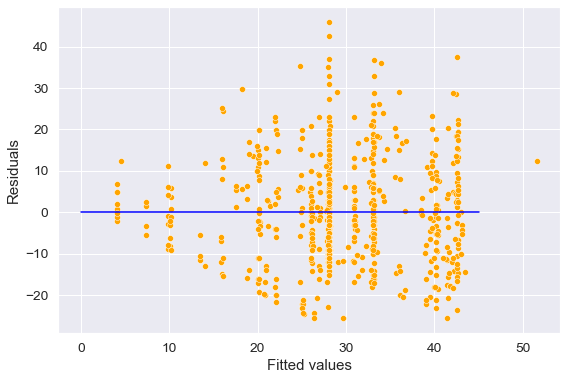

In [11]:
#Checking Model Assumptions

#Plotting residuals vs fitted values
plt.rcParams["figure.figsize"] = (9,6)
sns.set(font_scale=1.25)
ax = sns.scatterplot(x = model.fittedvalues, y=model.resid,color = 'orange')
sns.lineplot(x = [0,45],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

Does not violate non-linearity of data, but there does seem to be non-constant variance of error terms. Take sqrt transformation of Age and see if it resolves this issue:

In [12]:
ols_object = smf.ols(formula = 'np.sqrt(Age)~SibSp+Parch+Pclass+Fare', data = has_age)
model_sqrt_age = ols_object.fit()
model_sqrt_age.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.sqrt(Age)   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     26.74
Date:                Sun, 12 Mar 2023   Prob (F-statistic):           3.89e-56
Time:                        23:59:23   Log-Likelihood:                -1141.2
No. Observations:                 714   AIC:                             2312.
Df Residuals:                     699   BIC:                             2381.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.5176      0.134     48.479      0.000       6.254       6.782
SibSp[T.1]     -0.1719      0.113     -1.522      0.128      -0.394       0.050
SibSp[T.2]     -0.7000      0.253     -2.764      0.006      -1.197      -0.203
SibSp[T.3]     -1.0391      0.371     -2.803      0.005      -1.767      -0.311
SibSp[T.4]     -1.5136      0.314     -4.816      0.000      -2.131      -0.896
SibSp[T.5]     -0.7256      0.571     -1.271      0.204      -1.847       0.395
Parch[T.1]     -0.9035      0.138     -6.556      0.000      -1.174      -0.633
Parch[T.2]     -1.4262      0.179     -7.977      0.000      -1.777      -1.075
Parch[T.3]      0.4934      0.549      0.899      0.369      -0.584       1.571
Parch[T.4]      1.2739      0.615      2.072      0.039       0.067       2.481
Parch[T.5]      1.1880      0.549      2.165      0.031       0.111       2.265
Parch[T.6]      1.5659      1.216      1.288      0.198      -0.822       3.954
Pclass[T.2]    -0.8557      0.149     -5.762      0.000      -1.147      -0.564
Pclass[T.3]    -1.3142      0.142     -9.284      0.000      -1.592      -1.036
Fare           -0.0009      0.001     -0.751      0.453      -0.003       0.001
==============================================================================
Omnibus:                        6.406   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                6.815
Skew:                          -0.162   Prob(JB):                       0.0331
Kurtosis:                       3.352   Cond. No.                     1.70e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared improves a bit. Let's check the residuals

Text(0, 0.5, 'Residuals')

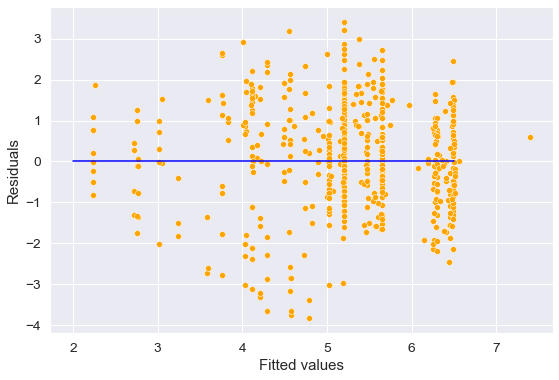

In [13]:
#Plotting residuals vs fitted values
plt.rcParams["figure.figsize"] = (9,6)
sns.set(font_scale=1.25)
ax = sns.scatterplot(x = model_sqrt_age.fittedvalues, y=model_sqrt_age.resid,color = 'orange')
sns.lineplot(x = [2,6.5],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

Better. Not really worth doing any variable transformations since Fare isn't significant in this model anyways, and the rest of the variables are categorical. As a last step, see if we need to remove outliers, high leverage points, and influential points

Text(0, 0.5, 'Studentized Residuals')

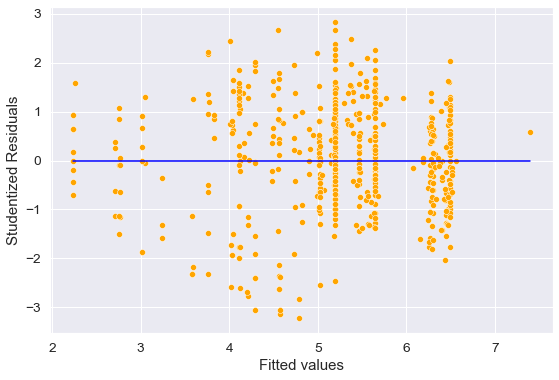

In [14]:
#Studentized residuals
out = model_sqrt_age.outlier_test()
#Plotting studentized residuals vs fitted values
sns.scatterplot(x = (model_sqrt_age.fittedvalues), y=(out.student_resid),color = 'orange')
sns.lineplot(x = [model_sqrt_age.fittedvalues.min(),model_sqrt_age.fittedvalues.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Studentized Residuals')

In [15]:
influence = model_sqrt_age.get_influence()
leverage = influence.hat_matrix_diag
average_leverage = (model_sqrt_age.df_model+1)/model_sqrt_age.nobs
high_leverage_threshold = 3*average_leverage
np.sum(leverage>high_leverage_threshold)

37

Seems to be 4 outliers (studentized residuals larger than 3) and 37 high leverage points. None of them are influential points

Now we can predict age! In the missing_age dataframe, there are 7 rows where 'SibSp' = 8, but our model which includes people that have age only includes 'SibSp' from 1 to 5. Hence, the model can't fit those values. Maybe we can hand-impute them?

In [16]:
missing_age.loc[missing_age['SibSp']=='8']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


They all seem to come from the same family! Did a little bit of research, and found some information about this family: Stella (born 1891), George John (born 1892), Douglas Bullen (born 1894), Frederick (born 1895), Dorothy Florence (born 1897), Anthony William (born 1899), Elizabeth Ada (born 1901), Constance Gladys (born 1904), Thomas Henry (born 1911). Soure: https://www.nationalarchives.gov.uk/titanic/stories/sage-family.htm

Titanic sunk in 1912\
Thomas: 1\
Constance: 8\
Fredrick: 17\
George: 20\
Stella: 21\
Douglas: 18\
Dorothy: 15

Add these values into "train" dataframe, re-make missing_age and has_age, rerun model, then do prediction!

In [17]:
train.loc[159,'Age']=1
train.loc[180,'Age']=8
train.loc[201,'Age']=17
train.loc[324,'Age']=20
train.loc[792,'Age']=21
train.loc[846,'Age']=18
train.loc[863,'Age']=15
missing_age = train[train['Age'].isna()] #dataframe containing only rows missing Age
has_age = train.dropna(subset=['Age']) #dataframe containing only no rows missing Age
ols_object = smf.ols(formula = 'np.sqrt(Age)~SibSp+Parch+Pclass+Fare', data = has_age)
model_age_final = ols_object.fit()
model_age_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           np.sqrt(Age)   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     25.80
Date:                Sun, 12 Mar 2023   Prob (F-statistic):           2.59e-57
Time:                        23:59:24   Log-Likelihood:                -1152.4
No. Observations:                 721   AIC:                             2337.
Df Residuals:                     705   BIC:                             2410.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.5176      0.135     48.454      0.000       6.253       6.782
SibSp[T.1]     -0.1719      0.113     -1.521      0.129      -0.394       0.050
SibSp[T.2]     -0.7000      0.253     -2.762      0.006      -1.198      -0.202
SibSp[T.3]     -1.0391      0.371     -2.802      0.005      -1.767      -0.311
SibSp[T.4]     -1.5136      0.314     -4.813      0.000      -2.131      -0.896
SibSp[T.5]     -0.7256      0.571     -1.270      0.204      -1.847       0.396
SibSp[T.8]     -0.1291      0.494     -0.261      0.794      -1.099       0.841
Parch[T.1]     -0.9035      0.138     -6.553      0.000      -1.174      -0.633
Parch[T.2]     -1.4262      0.179     -7.973      0.000      -1.777      -1.075
Parch[T.3]      0.4934      0.549      0.899      0.369      -0.584       1.571
Parch[T.4]      1.2739      0.615      2.071      0.039       0.066       2.482
Parch[T.5]      1.1880      0.549      2.164      0.031       0.110       2.266
Parch[T.6]      1.5659      1.217      1.287      0.199      -0.823       3.955
Pclass[T.2]    -0.8557      0.149     -5.759      0.000      -1.147      -0.564
Pclass[T.3]    -1.3142      0.142     -9.280      0.000      -1.592      -1.036
Fare           -0.0009      0.001     -0.750      0.453      -0.003       0.001
==============================================================================
Omnibus:                        6.916   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                7.342
Skew:                          -0.173   Prob(JB):                       0.0255
Kurtosis:                       3.353   Cond. No.                     1.71e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
missing_age['Age'] = model_age_final.predict(missing_age)**2 #predicting based on dataframe with ages
train_with_age = pd.concat([has_age,missing_age]) #putting two dataframes together

C:\Users\david\AppData\Local\Temp/ipykernel_6288/3789173762.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_age['Age'] = model_age_final.predict(missing_age)**2 #predicting based on dataframe with ages


In [19]:
train_with_age

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
849,850,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,39.310024,1,0,17453,89.1042,C92,C
859,860,0,3,"Razi, Mr. Raihed",male,27.011221,0,0,2629,7.2292,NaN,C
868,869,0,3,"van Melkebeke, Mr. Philemon",male,26.991118,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,27.005319,0,0,349217,7.8958,NaN,S


Binning Ages:

In [20]:
#Binning Age
binned_age = pd.cut(train_with_age['Age'],8,retbins=True)
train_with_age['age_binned'] = binned_age[0]
age_data = train_with_age.groupby('age_binned')['Survived'].agg([('survival_percent','mean'),('nobs','count')]).reset_index(drop=False)

## Exploratory data analysis

All of the code done for Exploratory data analysis is already included in the report!

## Variable Selection and Preliminary Analysis

David Venator

In [21]:
train_with_age.dtypes

PassengerId       int64
Survived          int64
Pclass           object
Name             object
Sex              object
Age             float64
SibSp            object
Parch            object
Ticket           object
Fare            float64
Cabin            object
Embarked         object
age_binned     category
dtype: object

In [22]:
#Import Statement

import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time

In [23]:
train_with_age['SibSp'] = train_with_age['SibSp'].apply(lambda x: int(x))
train_with_age['Parch'] = train_with_age['Parch'].apply(lambda x: int(x))

In [24]:
#Extract predictors remaining after EDA and preliminary Processing

predictors = train_with_age.columns.tolist()[2:]
X = train_with_age[predictors]

In [25]:
#Perform single variable logistic regression, noting which variables throw errors

to_drop = []
solo = {}
for pred in predictors:
    factor = pred
    try:
        model = sm.logit('Survived~' + factor, data = train_with_age).fit()
        #print(model.pvalues)
        solo[pred] = model
    except:
        to_drop.append(pred)
        print(pred, 'does not model')
        
print(to_drop)

Optimization terminated successfully.
         Current function value: 0.607805
         Iterations 5
         Current function value: 0.000000
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.515041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664720
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.665272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.662650
         Iterations 4


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.093416
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.627143
         Iterations 6
         Current function value: inf
         Iterations: 35
Cabin does not model
Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.653726
         Iterations 5
['Cabin']


C:\Users\david\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\david\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


In [26]:
#Check for illogical regressions - pvalues are NaN, or pvalues have an average of 1 (no significance)

for key in list(solo.keys()):
    if solo[key].pvalues.isna().value_counts()[False] < sum(solo[key].pvalues.isna().value_counts()):
        to_drop.append(key)
    elif (solo[key].pvalues > 0.99).mean() == 1:
        to_drop.append(key)

In [27]:
#This shows the columns that either did not regress, or had irregular p-values

print(to_drop)

['Cabin', 'Name', 'Ticket']


In [28]:
#Drops these columns from analysis

X = X.drop(columns = to_drop)
for dropped in to_drop:
    if dropped in list(solo.keys()):
        del solo[dropped]

Pclass params are
                     0             1
Intercept    0.530628  1.658975e-04
Pclass[T.2] -0.639431  1.730629e-03
Pclass[T.3] -1.670399  2.186643e-21
Sex params are
                     0             1
Intercept    1.056589  2.580544e-16
Sex[T.male] -2.513710  4.259191e-51
Age params are
                   0         1
Intercept -0.253953  0.124427
Age       -0.007512  0.146507
SibSp params are
                   0             1
Intercept -0.438154  9.226474e-09
SibSp     -0.068638  2.937996e-01
Parch params are
                   0             1
Intercept -0.553050  6.365101e-13
Parch      0.203317  1.626848e-02
Fare params are
                   0             1
Intercept -0.941330  4.384310e-23
Fare       0.015197  9.857415e-12
Embarked params are
                       0             1
Intercept      0.215111  1.657297e-01
Embarked[T.Q] -0.664062  1.792398e-02
Embarked[T.S] -0.891998  4.121688e-07


C:\Users\david\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


age_binned params are
                                                            0         1
Intercept                                           0.305382  0.220144
age_binned[T.Interval(10.368, 20.315, closed='r... -0.824175  0.007165
age_binned[T.Interval(20.315, 30.263, closed='r... -1.037921  0.000155
age_binned[T.Interval(30.263, 40.21, closed='ri... -0.477232  0.101767
age_binned[T.Interval(40.21, 50.158, closed='ri... -0.821195  0.010116
age_binned[T.Interval(50.158, 60.105, closed='r... -0.691044  0.084885
age_binned[T.Interval(60.105, 70.052, closed='r... -1.484037  0.017333
age_binned[T.Interval(70.052, 80.0, closed='rig... -1.691676  0.139708


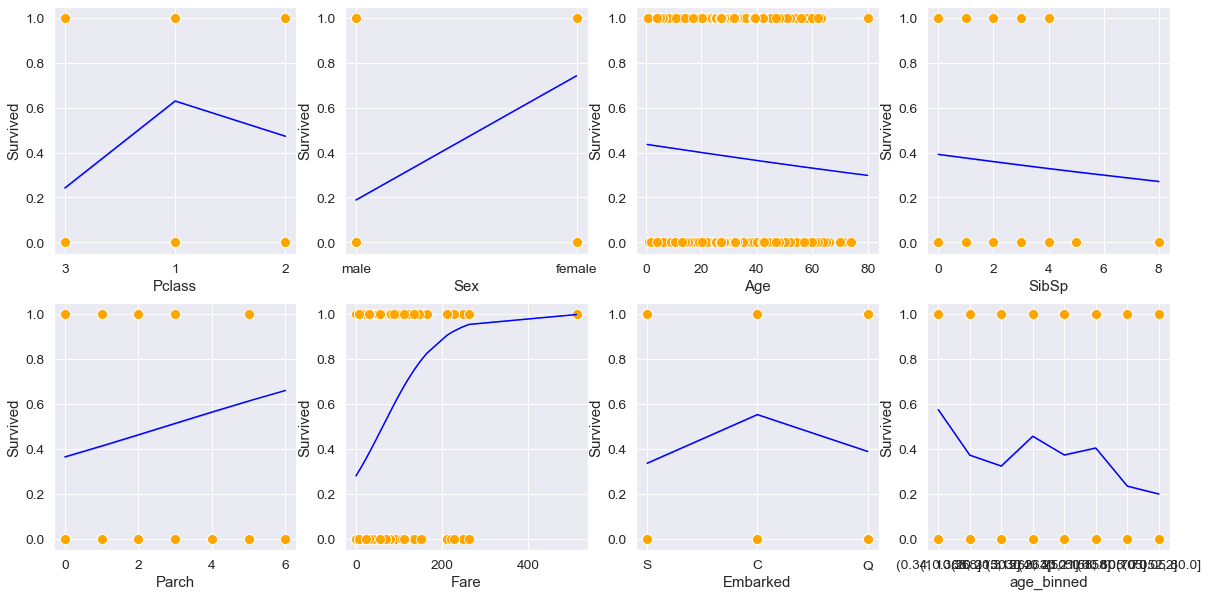

In [29]:
#Plots the single variable regression for all potential predictors after first filter - prints all coeffictients(0) and pvalues(1) for further examiniation

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

for i in range(len(list(solo.keys()))):
    print(solo[list(solo.keys())[i]])
    plt.subplot(2, 4, i+1)
    if list(solo.keys())[i] == 'age_binned':
        sns.scatterplot(train_with_age[list(solo.keys())[i]].apply(lambda x: str(x)), train_with_age['Survived'], color = 'orange') #Visualizing data
        logit_model = solo[list(solo.keys())[i]]
        print(list(solo.keys())[i], 'params are\n', pd.concat([solo[list(solo.keys())[i]].params, solo[list(solo.keys())[i]].pvalues], axis = 1))
        sns.lineplot(train_with_age[list(solo.keys())[i]].apply(lambda x: str(x)), logit_model.predict(train_with_age), color = 'blue') #Visualizing model
    else: 
        sns.scatterplot(x = list(solo.keys())[i], y = 'Survived', data = train_with_age, color = 'orange') #Visualizing data
        logit_model = solo[list(solo.keys())[i]]
        print(list(solo.keys())[i], 'params are\n', pd.concat([solo[list(solo.keys())[i]].params, solo[list(solo.keys())[i]].pvalues], axis = 1))
        sns.lineplot(x = list(solo.keys())[i], y = logit_model.predict(train_with_age), data = train_with_age, color = 'blue') #Visualizing model
    

In [30]:
model_breakers = []

def processSubset(predictor_subset):
    model = sm.logit('Survived~' + '+'.join(predictor_subset),data = train_with_age).fit()
    pval = model.prsquared
    return {"model":model, "llr_pvalue":pval, "vars":predictor_subset}

def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        #print(list(combo))
        try:
            results.append(processSubset((list(combo))))
        except:
            model_breakers.append(list(combo))
  
    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)
    #print(models)

    # Choose the model with the highest RSS
    best_model = models.loc[models['llr_pvalue'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return k, models

#Function to select the best model amongst the best models for 'k' predictors, where k = 1,2,3,..
models_best = pd.DataFrame(columns=['num_elements', "model"])

tic = time.time()
for i in range(1,1+X.shape[1]):
    try:
        models_best.loc[i] = getBest_model(i)
    except:
        print('error')

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Optimization terminated successfully.
         Current function value: 0.607805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664720
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.665272
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.662650
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.627143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.653726
         Iterations 5
Processed 8 models on 1 predictors in 0.15600991249084473 seconds.
Optimization terminated successfully.
         Current function value: 0.464023
         Iterations 6
Optimization te

Optimization terminated successfully.
         Current function value: 0.616528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.635688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608772
         Iterations 6
Processed 56 models on 3 predictors in 1.4681084156036377 seconds.
Optimization terminated successfully.
         Current function value: 0.441694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459565
         Iterations 6
Optimization te

Optimization terminated successfully.
         Current function value: 0.448682
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.448652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459143
  

         Current function value: 0.458330
         Iterations 7
Processed 8 models on 7 predictors in 0.3210268020629883 seconds.
Optimization terminated successfully.
         Current function value: 0.431055
         Iterations 6
Processed 1 models on 8 predictors in 0.044002532958984375 seconds.
Total elapsed time: 7.330534219741821 seconds.


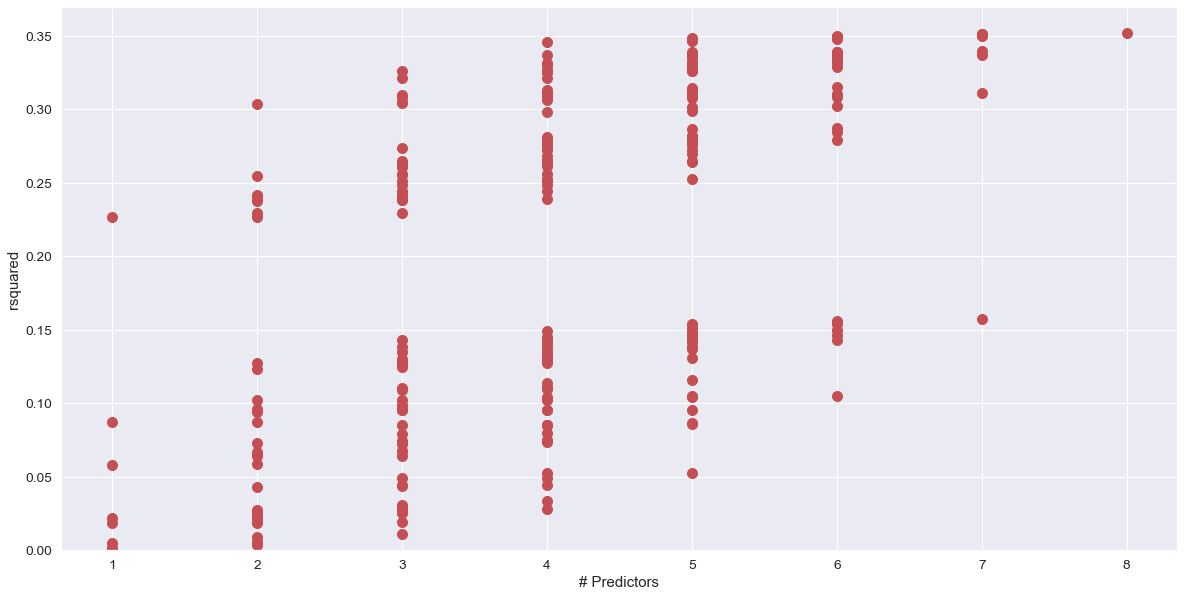

In [31]:
#Plots all generated models based on r-squared - clear separation is seen

def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    #plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plot_array = []
    for i in range(1, models_best.shape[0]+1):
        #print(i)
        models_made = models_best.loc[models_best['num_elements'] == i]['model'][i]
        for k in range(models_made.shape[0]):
            plot_array.append([i, models_made['model'], models_made['llr_pvalue'][k], models_made['vars'][k]])
        
    data = pd.DataFrame(plot_array, columns = ['num_elements', 'model', 'rsquared', 'vars'])
    plt.plot(data['num_elements'], data['rsquared'], 'ro')
    plt.xlabel('# Predictors')
    plt.ylabel('rsquared')
    plt.ylim(bottom=0)
    
    return data

all_models = best_sub_plots()

In [32]:
#Creates a datefram including the model, its psuedo r-squared, the variables considered, and booleans for whether a given variable was used

def new_col(var, dfr):
    return dfr['vars'].apply(lambda x: var in x)

for variable in list(X.columns):
    all_models[variable] = new_col(variable, all_models)    

In [33]:
#Shows the percentage of models including a given veriable when the pseudo r-squared is over 0.2 (boundary between regions)

all_models[all_models.rsquared > 0.2][list(X.columns)].sum()/all_models['Sex'].sum()

Pclass        0.5
Sex           1.0
Age           0.5
SibSp         0.5
Parch         0.5
Fare          0.5
Embarked      0.5
age_binned    0.5
dtype: float64

In [34]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = train_with_age[predictors].select_dtypes(include=numerics)

X_v = newdf.columns

In [35]:
#Checks correlation of all numeric values

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X_vif = add_constant(train_with_age[X_v])
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns

for i in range(len(X_vif.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X_vif.values, i)

print(vif_data)

  feature       VIF
0   const  7.518736
1     Age  1.155832
2   SibSp  1.305607
3   Parch  1.263905
4    Fare  1.094940


C:\Users\david\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


## Developing the model

**All of the folllowing code produced by Hiba Khatib & Emily Leibfritz**

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

In [36]:
final_train = train_with_age.drop(columns = ['PassengerId', 'Name', 'Ticket'])

In [37]:
logit_model1 = sm.logit(formula = 'Survived~ Pclass + Sex + Age + SibSp + Parch + Fare + Embarked + age_binned', data = final_train).fit()
logit_model1.summary()

Optimization terminated successfully.
         Current function value: 0.431055
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  889
Model:                          Logit   Df Residuals:                      872
Method:                           MLE   Df Model:                           16
Date:                Sun, 12 Mar 2023   Pseudo R-squ.:                  0.3520
Time:                        23:59:48   Log-Likelihood:                -383.21
converged:                       True   LL-Null:                       -591.41
Covariance Type:            nonrobust   LLR p-value:                 1.322e-78
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                  5.3869      0.622      8.658      0.000       4.167       6.606
Pclass[T.2]                                               -1.0010      0.317     -3.160      0.002      -1.622      -0.380
Pclass[T.3]                                               -2.1442      0.327     -6.549      0.000      -2.786      -1.502
Sex[T.male]                                               -2.7955      0.208    -13.462      0.000      -3.203      -2.388
Embarked[T.Q]                                             -0.0277      0.386     -0.072      0.943      -0.785       0.729
Embarked[T.S]                                             -0.4359      0.246     -1.771      0.077      -0.918       0.046
age_binned[T.Interval(10.368, 20.315, closed='right')]    -1.4495      0.618     -2.344      0.019      -2.661      -0.238
age_binned[T.Interval(20.315, 30.263, closed='right')]    -1.4118      0.833     -1.695      0.090      -3.044       0.220
age_binned[T.Interval(30.263, 40.21, closed='right')]     -0.8849      1.106     -0.800      0.424      -3.054       1.284
age_binned[T.Interval(40.21, 50.158, closed='right')]     -1.2047      1.420     -0.848      0.396      -3.988       1.579
age_binned[T.Interval(50.158, 60.105, closed='right')]    -1.0216      1.772     -0.576      0.564      -4.495       2.452
age_binned[T.Interval(60.105, 70.052, closed='right')]    -1.2111      2.127     -0.569      0.569      -5.381       2.959
age_binned[T.Interval(70.052, 80.0, closed='right')]      -0.5768      2.611     -0.221      0.825      -5.694       4.540
Age                                                       -0.0383      0.033     -1.149      0.250      -0.104       0.027
SibSp                                                     -0.4749      0.123     -3.861      0.000      -0.716      -0.234
Parch                                                     -0.2200      0.130     -1.695      0.090      -0.475       0.034
Fare                                                       0.0028      0.003      1.050      0.294      -0.002       0.008
==========================================================================================================================
"""

In [38]:
final_train = train_with_age.drop(columns = ['PassengerId', 'Name', 'Ticket', 'Cabin'])

In [39]:
final_train = pd.get_dummies(final_train, columns = ['Sex'], drop_first = True)

In [40]:
final_train.rename(columns={"Sex_male": "Sex"}, inplace = True)

In [41]:
final_train['Embarked'] = final_train['Embarked'].apply(lambda x: 1 if x == 'S' else 
                                                               2 if x == 'C' else 
                                                               0)

In [42]:
X_train = final_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

In [43]:
y = final_train.Survived
X = final_train.drop('Survived', axis = 1)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 45)

In [45]:
X_train = X_train.drop('age_binned', axis = 1)
X_test = X_test.drop('age_binned', axis = 1)

In [46]:
sklearn_model = LogisticRegression(max_iter=500)
sklearn_model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [47]:
y_pred_test = sklearn_model.predict(X_test)
print('Accuracy of logistic regression on test set : {:.4f}'.format(sklearn_model.score(X_test, y_test)))

Accuracy of logistic regression on test set : 0.8060


In [48]:
def fit_logistic_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LogisticRegression()
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

In [49]:
k = 11
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#Looping over k = 1 to k = 11 features in X
for k in tnrange(1,len(X_train.columns) + 1, desc = 'Loop...'):

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X_train.columns,k):
        tmp_result = fit_logistic_reg(X_train[list(combo)],y_train)   #Store temp result 
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

C:\Users\david\AppData\Local\Temp/ipykernel_6288/3912636911.py:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(X_train.columns) + 1, desc = 'Loop...'):


Loop...:   0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\david\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]
display(df_min.head(10))
display(df_max.head(10))

,numb_features,RSS,R_squared,features
6,1,159.0,0.789960,"(Sex,)"
21,2,152.0,0.799207,"(SibSp, Sex)"
36,3,146.0,0.807133,"(Pclass, SibSp, Sex)"
66,4,142.0,0.812417,"(Pclass, Age, SibSp, Sex)"
103,5,141.0,0.813738,"(Pclass, Age, SibSp, Embarked, Sex)"
121,6,141.0,0.813738,"(Pclass, Age, SibSp, Parch, Embarked, Sex)"
126,7,143.0,0.811096,"(Pclass, Age, SibSp, Parch, Fare, Embarked, Sex)"


,numb_features,RSS,R_squared,features
6,1,159.0,0.789960,"(Sex,)"
21,2,152.0,0.799207,"(SibSp, Sex)"
36,3,146.0,0.807133,"(Pclass, SibSp, Sex)"
66,4,142.0,0.812417,"(Pclass, Age, SibSp, Sex)"
103,5,141.0,0.813738,"(Pclass, Age, SibSp, Embarked, Sex)"
121,6,141.0,0.813738,"(Pclass, Age, SibSp, Parch, Embarked, Sex)"
126,7,143.0,0.811096,"(Pclass, Age, SibSp, Parch, Fare, Embarked, Sex)"


In [51]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df.head()

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
0,1,246.0,0.675033,"(Pclass,)",159.0,0.78996
1,1,285.0,0.623514,"(Age,)",159.0,0.78996
2,1,285.0,0.623514,"(SibSp,)",159.0,0.78996
3,1,290.0,0.616909,"(Parch,)",159.0,0.78996
4,1,252.0,0.667107,"(Fare,)",159.0,0.78996


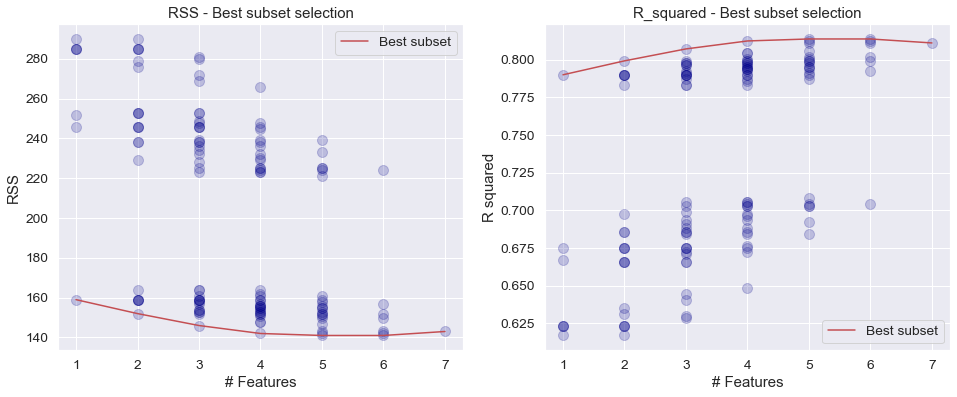

In [52]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

In [53]:
df[(df["numb_features"] == 6)].sort_values(by = ['R_squared'], ascending=False)

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
121,6,141.0,0.813738,"(Pclass, Age, SibSp, Parch, Embarked, Sex)",141.0,0.813738
122,6,142.0,0.812417,"(Pclass, Age, SibSp, Fare, Embarked, Sex)",141.0,0.813738
120,6,143.0,0.811096,"(Pclass, Age, SibSp, Parch, Fare, Sex)",141.0,0.813738
124,6,150.0,0.801849,"(Pclass, SibSp, Parch, Fare, Embarked, Sex)",141.0,0.813738
123,6,152.0,0.799207,"(Pclass, Age, Parch, Fare, Embarked, Sex)",141.0,0.813738
125,6,157.0,0.792602,"(Age, SibSp, Parch, Fare, Embarked, Sex)",141.0,0.813738
119,6,224.0,0.704095,"(Pclass, Age, SibSp, Parch, Fare, Embarked)",141.0,0.813738


In [54]:
df[(df["numb_features"] == 7)].sort_values(by = ['R_squared'], ascending=False)

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
126,7,143.0,0.811096,"(Pclass, Age, SibSp, Parch, Fare, Embarked, Sex)",143.0,0.811096


In [55]:
### Selected variables: (Pclass, Age, SibSp, Parch, Embarked, Sex)	

In [56]:
X_train = X_train.drop('Fare', axis = 1)
X_test = X_test.drop('Fare', axis = 1)

In [57]:
sklearn_model = LogisticRegression()
sklearn_model.fit(X_train, y_train)

y_pred_test = sklearn_model.predict(X_test)
print('Accuracy of logistic regression on test set : {:.4f}'.format(sklearn_model.score(X_test, y_test)))

Accuracy of logistic regression on test set : 0.8060


In [58]:
final_train.dtypes

Survived         int64
Pclass          object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked         int64
age_binned    category
Sex              uint8
dtype: object

In [59]:
final_train['SibSp'] = pd.to_numeric(final_train['SibSp'])
final_train['Parch'] = pd.to_numeric(final_train['Parch'])
final_train['Pclass'] = pd.to_numeric(final_train['Pclass'])

<AxesSubplot:xlabel='SibSp', ylabel='Parch'>

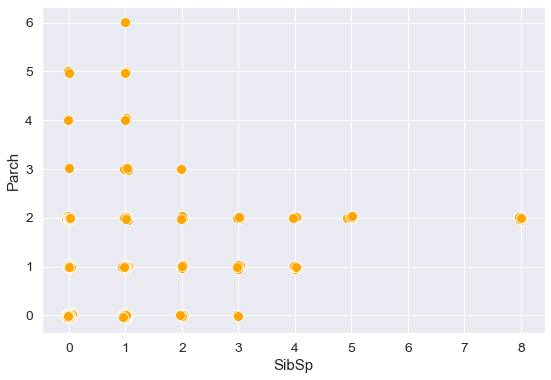

In [60]:
# Interacation between SibSp and Parch

def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x=jitter(final_train.SibSp,0), y = jitter(final_train.Parch,0),data = final_train, color = 'orange')

Optimization terminated successfully.
         Current function value: 0.665272
         Iterations 4


-592.757347593184

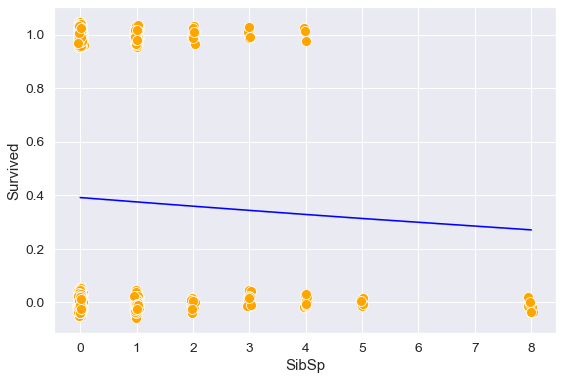

In [61]:
# SibSP
sns.scatterplot(x = jitter(final_train.SibSp,0), y = jitter(final_train.Survived,0), color = 'orange')
model = smf.logit(formula = 'Survived~SibSp', data = final_train).fit()
sns.lineplot(x = 'SibSp', y= model.predict(final_train), data = final_train, color = 'blue') 
model.llf

Optimization terminated successfully.
         Current function value: 0.643756
         Iterations 8


-573.5865261165274

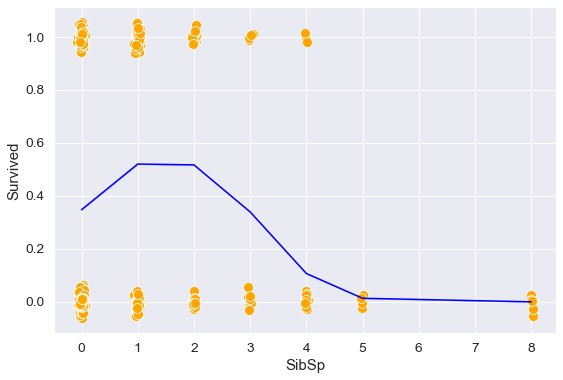

In [62]:
# SibSP squared
sns.scatterplot(x = jitter(final_train.SibSp,0), y = jitter(final_train.Survived,0), color = 'orange')
model = smf.logit(formula = 'Survived~SibSp+I(SibSp**2)', data = final_train).fit()
sns.lineplot(x = 'SibSp', y= model.predict(final_train), data = final_train, color = 'blue') 
model.llf

Optimization terminated successfully.
         Current function value: 0.662650
         Iterations 4


-590.4208347129161

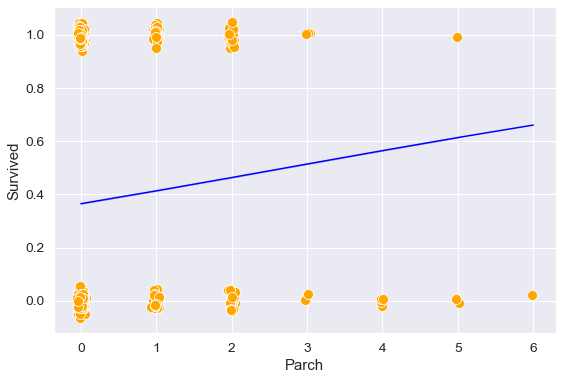

In [63]:
# Parch
sns.scatterplot(x = jitter(final_train.Parch,0), y = jitter(final_train.Survived,0), color = 'orange')
model = smf.logit(formula = 'Survived~Parch', data = final_train).fit()
sns.lineplot(x = 'Parch', y= model.predict(final_train), data = final_train, color = 'blue') 
model.llf

Optimization terminated successfully.
         Current function value: 0.652399
         Iterations 6


-581.2876779431224

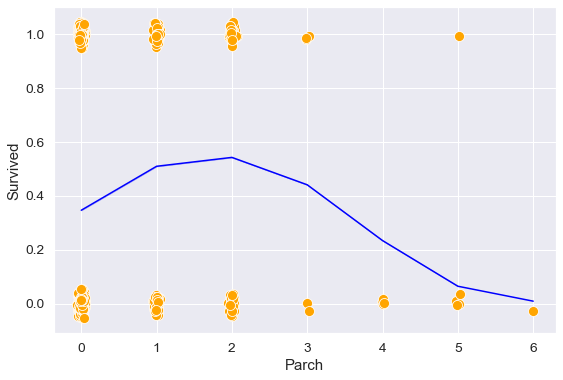

In [64]:
# Parch squared
sns.scatterplot(x = jitter(final_train.Parch,0), y = jitter(final_train.Survived,0), color = 'orange')
model = smf.logit(formula = 'Survived~Parch+I(Parch**2)', data = final_train).fit()
sns.lineplot(x = 'Parch', y= model.predict(final_train), data = final_train, color = 'blue') 
model.llf

Optimization terminated successfully.
         Current function value: 0.664720
         Iterations 4


-592.2653694984031

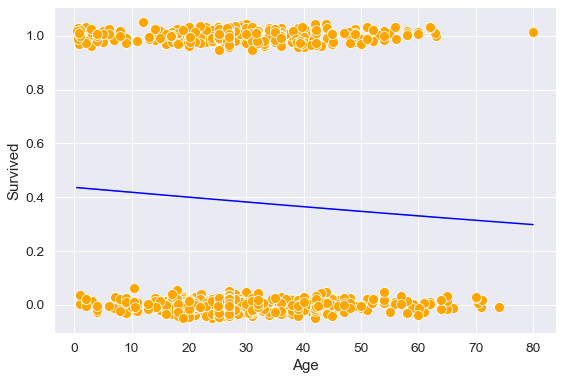

In [65]:
# age not binned
sns.scatterplot(x = jitter(final_train.Age,0), y = jitter(final_train.Survived,0), color = 'orange')
model = smf.logit(formula = 'Survived~Age', data = final_train).fit()
sns.lineplot(x = 'Age', y= model.predict(final_train), data = final_train, color = 'blue') 
model.llf

Optimization terminated successfully.
         Current function value: 0.653726
         Iterations 5


-582.4699080051051

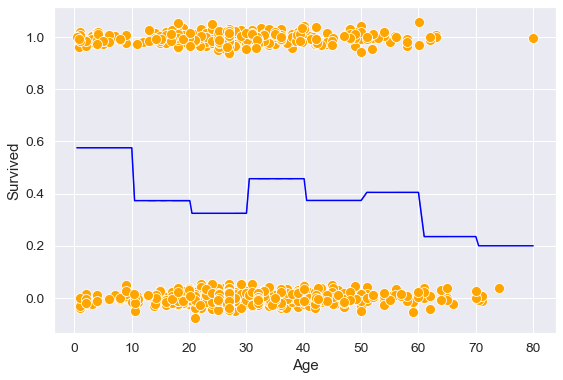

In [66]:
# age binned
sns.scatterplot(x = jitter(final_train.Age,0), y = jitter(final_train.Survived,0), color = 'orange')
model = smf.logit(formula = 'Survived~age_binned', data = final_train).fit()
sns.lineplot(x = 'Age', y= model.predict(final_train), data = final_train, color = 'blue') 
model.llf

Optimization terminated successfully.
         Current function value: 0.662790
         Iterations 4


-590.5460466776819

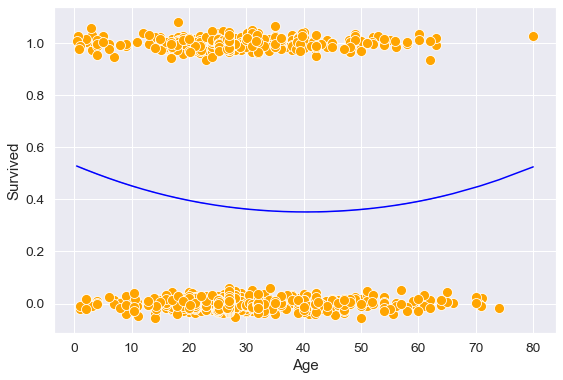

In [67]:
# age squared
sns.scatterplot(x = jitter(final_train.Age,0), y = jitter(final_train.Survived,0), color = 'orange')
model = smf.logit(formula = 'Survived~Age+I(Age**2)', data = final_train).fit()
sns.lineplot(x = 'Age', y= model.predict(final_train), data = final_train, color = 'blue') 
model.llf

<AxesSubplot:xlabel='age_binned', ylabel='count'>

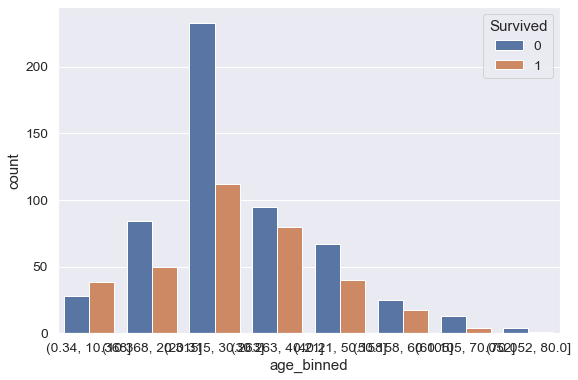

In [68]:
sns.countplot(x = 'age_binned',hue = 'Survived', data = final_train )

In [69]:
final_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,age_binned,Sex
0,0,3,22.0,1,0,7.2500,1,"(20.315, 30.263]",1
1,1,1,38.0,1,0,71.2833,2,"(30.263, 40.21]",0
2,1,3,26.0,0,0,7.9250,1,"(20.315, 30.263]",0
3,1,1,35.0,1,0,53.1000,1,"(30.263, 40.21]",0
4,0,3,35.0,0,0,8.0500,1,"(30.263, 40.21]",1


In [70]:
X_train1 = X_train.copy()
X_train1['Age_binned'] = final_train['age_binned']
X_train1['agePclass']= final_train.Age * final_train.Pclass
X_train1['ParchSibSp']= final_train.SibSp * final_train.Parch
X_train1['EmbarkedPclass']= final_train.Embarked * final_train.Pclass
X_train1 = X_train1.drop(['Age_binned'], axis = 1)

In [71]:
X_test1 = X_test.copy()
X_test1['Parch'] = pd.to_numeric(X_test1.Parch)
X_test1['SibSp'] = pd.to_numeric(X_test1.SibSp)
X_test1['Pclass'] = pd.to_numeric(X_test1.Pclass)
X_test1['agePclass']= X_test1.Age * X_test1.Pclass
X_test1['ParchSibSp']= X_test1.SibSp * X_test1.Parch
X_test1['EmbarkedPclass']= X_test1.Embarked * X_test1.Pclass

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

In [72]:
sklearn_model_1 = LogisticRegression()
sklearn_model_1.fit(X_train1, y_train)

C:\Users\david\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [73]:
y_pred_test = sklearn_model_1.predict(X_test1)
print('Accuracy of logistic regression on test set : {:.4f}'.format(sklearn_model_1.score(X_test1, y_test)))

Accuracy of logistic regression on test set : 0.7910


In [74]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83        77
           1       0.80      0.68      0.74        57

    accuracy                           0.79       134
   macro avg       0.79      0.78      0.78       134
weighted avg       0.79      0.79      0.79       134



### Performance Measurement 

Confusion Matrix : 
 [[67 10]
 [18 39]]
Test accuracy =  0.7910447761194029


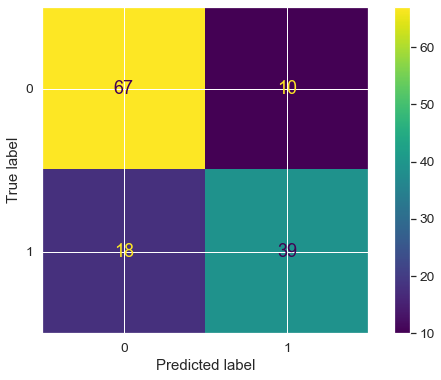

In [75]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_test) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, y_pred_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=sklearn_model_1.classes_)
disp.plot()

plt.show()

C:\Users\david\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


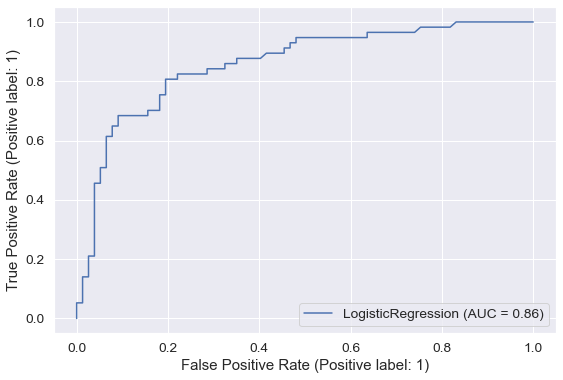

In [76]:
metrics.plot_roc_curve(sklearn_model_1, X_test1, y_test)
plt.show()

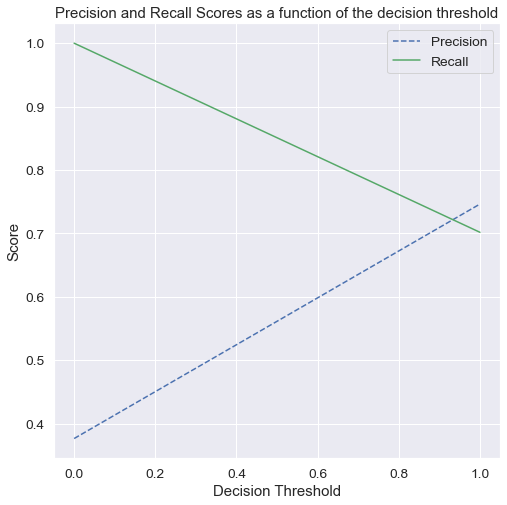

In [77]:
ypred = sklearn_model_1.predict(X_train1)
y = y_train
# ypred = logit_model_diabetes.predict(train)
p, r, thresholds = precision_recall_curve(y, ypred)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

## Model Summary, Coefficients and P-Values

David Ventor

In [78]:
X_train1.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Embarked', 'Sex', 'agePclass',
       'ParchSibSp', 'EmbarkedPclass'],
      dtype='object')

In [79]:
final_model = sm.logit('Survived~Pclass+Age+SibSp+Parch+Embarked+Sex+Age*Pclass+Embarked*Pclass',data = train_with_age).fit()
final_model.summary()

Optimization terminated successfully.
         Current function value: 0.438109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  889
Model:                          Logit   Df Residuals:                      874
Method:                           MLE   Df Model:                           14
Date:                Mon, 13 Mar 2023   Pseudo R-squ.:                  0.3414
Time:                        00:00:04   Log-Likelihood:                -389.48
converged:                       True   LL-Null:                       -591.41
Covariance Type:            nonrobust   LLR p-value:                 1.949e-77
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     4.0693      0.623      6.530      0.000       2.848       5.291
Pclass[T.2]                  -0.5288      0.937     -0.564      0.573      -2.366       1.308
Pclass[T.3]                  -1.9166      0.735     -2.606      0.009      -3.358      -0.475
Embarked[T.Q]                -0.8596      2.001     -0.430      0.667      -4.781       3.062
Embarked[T.S]                -0.2363      0.353     -0.669      0.503      -0.928       0.456
Sex[T.male]                  -2.7381      0.205    -13.356      0.000      -3.140      -2.336
Embarked[T.Q]:Pclass[T.2]     1.6525      2.873      0.575      0.565      -3.979       7.284
Embarked[T.S]:Pclass[T.2]     0.0812      0.749      0.108      0.914      -1.387       1.549
Embarked[T.Q]:Pclass[T.3]     0.5458      2.047      0.267      0.790      -3.467       4.559
Embarked[T.S]:Pclass[T.3]    -0.4961      0.505     -0.983      0.326      -1.485       0.493
Age                          -0.0349      0.013     -2.660      0.008      -0.061      -0.009
Age:Pclass[T.2]              -0.0237      0.020     -1.195      0.232      -0.062       0.015
Age:Pclass[T.3]              -0.0031      0.019     -0.164      0.870      -0.041       0.034
SibSp                        -0.3319      0.115     -2.896      0.004      -0.556      -0.107
Parch                        -0.0882      0.119     -0.741      0.459      -0.321       0.145
=============================================================================================
"""

## Conclusions and Recommendations to stakeholder(s)

# You may or may not have code to put in this section. Delete this section if it is irrelevant.

As we are analyzing a historical event, we do not have any recommendations to present as there are no stakeholders that would significantly benefit from our insights. 

In terms of conclusions, out optimized logistic model summary shows the factors that were the most impactful. The first thing that stands out, as it did throughout our analysis, was the impact of sex on survival. The coefficient for male was -2.7381, with a p-value rounding to ~0. This shows the that the stereotypical prioritization of women in survival situtations is historically accurate, with female survival rate being significantly higher. The second thing, that once again was in line with our expectations, was the dependance on class. The intercept coefficent, corresponding to class 1 passengers, has coefficent of 4.0693 with a p-value ~0 showing that the upper class passengers where able to survive at a significantly higher rate, especially compared to 3rd class (ceof = -1.9166, pval = 0.009). Interestingly the second class coefficient was not singificant, highlighting the gap between the highest and lowest class.

Another aspect that we expected to be significant was Age, to emphasize the expression 'women and children first' that was frequently stated in the movie, and is stereotypical of emergency situations even today. We were able to find a significant decrease in survival with Age (pval = 0.008), but the coefficient was just -0.0349, a lower impact than expected. Bucketing age did not appear useful, although in early analysis showed that this trend (lower survival with age) is not consistent across age groups. Another factor that may give insight into this area is the factors SubSp, and Parch, which show the number of siblings aboard and number of parents and children. The former was shown to have a moderate impact of -0.3319, with a pvalue 0.004. This indicates that larger families (children on board with more siblings) had more difficulty surviving, potentially skewing the age to have less impact than expected. 

Other factors lead to improved modeling outcomes, but did not carry significant in the model, making their impact less intuitive to understand. In general our analysis found that the stereotypical prioritization of women and children appears to exist, but gender seems to be a much larger predictor than age. Class was shown to be second only to gender, showing how even in crisis, those with higher class are able to secure better outcomes. These factors give insight into human nature, and confirm many aspects of people are traditional thought to react in emergencies. 

Overall, our model stil has shortcomings, with a recall of just 0.68, showing the difficulty in correctly identifying survived passengers when a clear majority did not survie, and in an emergency situation things are inherently unpredictable, to a degree. If this model were to be improved further, the focus would be on the precisions and recall for the survival values, as those are the minority. 